**Import Packages**

In [ ]:
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from google.colab import files
import pathlib

import flatbuffers
from tensorflow_lite_support.metadata import metadata_schema_py_generated as _metadata_fb
from tensorflow_lite_support.metadata.python import metadata as _metadata
from tensorflow_lite_support.metadata.python.metadata_writers import writer_utils
from tensorflow_lite_support.metadata.python.metadata_writers import image_classifier

**Load Data**

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Product Capstone/Development/ML/number_dataset.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
# Directory with number and alphabet pictures
number_0_dir = os.path.join('/tmp/number_dataset/0')
number_1_dir = os.path.join('/tmp/number_dataset/1')
number_2_dir = os.path.join('/tmp/number_dataset/2')
number_3_dir = os.path.join('/tmp/number_dataset/3')
number_4_dir = os.path.join('/tmp/number_dataset/4')
number_5_dir = os.path.join('/tmp/number_dataset/5')
number_6_dir = os.path.join('/tmp/number_dataset/6')
number_7_dir = os.path.join('/tmp/number_dataset/7')
number_8_dir = os.path.join('/tmp/number_dataset/8')
number_9_dir = os.path.join('/tmp/number_dataset/9')

In [ ]:
number_0 = os.listdir(number_0_dir)
number_1 = os.listdir(number_1_dir)
number_2 = os.listdir(number_2_dir)
number_3 = os.listdir(number_3_dir)
number_4 = os.listdir(number_4_dir)
number_5 = os.listdir(number_5_dir)
number_6 = os.listdir(number_6_dir)
number_7 = os.listdir(number_7_dir)
number_8 = os.listdir(number_8_dir)
number_9 = os.listdir(number_9_dir)

In [ ]:
# Printing the first 10 items in each directory
print(f'0: {number_0[:5]}')
print(f'1: {number_1[:5]}')
print(f'2: {number_2[:5]}')
print(f'3: {number_3[:5]}')
print(f'4: {number_4[:5]}')
print(f'5: {number_5[:5]}')
print(f'6: {number_6[:5]}')
print(f'7: {number_7[:5]}')
print(f'8: {number_8[:5]}')
print(f'9: {number_9[:5]}')

0: ['0_25_rotate_13.jpeg', '0_7_rotate_8.jpeg', '0_34_rotate_7.jpeg', '0_61_rotate_7.jpeg', '0_41_rotate_5.jpeg']
1: ['1_13_rotate_10.jpeg', 'IMG_5538.JPG', '1_10_rotate_8.jpeg', '1_70_rotate_8.jpeg', '1_43_rotate_8.jpeg']
2: ['IMG_4838.JPG', 'IMG_5076.JPG', '2_57_rotate_8.jpeg', '2_55_rotate_1.jpeg', '2_10_rotate_9.jpeg']
3: ['IMG_1253.JPG', '3_32_rotate_6.jpeg', '3_63_rotate_4.jpeg', '3_14_rotate_1.jpeg', '3_45_rotate_8.jpeg']
4: ['4_5_rotate_4.jpeg', '4_39_rotate_9.jpeg', 'IMG_4175.JPG', '4_32_rotate_4.jpeg', '4_17_rotate_4.jpeg']
5: ['5_14_rotate_6.jpeg', '5_49_rotate_9.jpeg', '5_36_rotate_2.jpeg', 'IMG_5609.JPG', '5_55_rotate_1.jpeg']
6: ['6_58_rotate_9.jpeg', '6_11_rotate_5.jpeg', 'IMG_4882.JPG', '6_17_rotate_2.jpeg', '6_4_rotate_1.jpeg']
7: ['IMG_5978.JPG', 'IMG_4671.JPG', 'IMG_5014.JPG', '7_69_rotate_8.jpeg', '7_15_rotate_8.jpeg']
8: ['8_29_rotate_4.jpeg', 'IMG_5545.JPG', '8_45_rotate_2.jpeg', '8_53_rotate_8.jpeg', '8_15_rotate_8.jpeg']
9: ['IMG_4845.JPG', '9_59_rotate_9.jpeg',

In [ ]:
# Concatenate paths to each directory
total_data = [
    number_0_dir, number_1_dir, number_2_dir, number_3_dir, number_4_dir, number_5_dir,
    number_6_dir, number_7_dir, number_8_dir, number_9_dir
]

# Initialize the variable for the total number of images
total_images = 0

# Iterate through all directories and count the number of files
for total in total_data:
    total_images += len(os.listdir(total))

print(f'Total images: {total_images}')

Total images: 9201


**Split Data**

In [ ]:
def split_data(source, training, validation, split_size):
    files = os.listdir(source)
    files = [file for file in files if os.path.getsize(os.path.join(source, file)) > 0]

    # Calculate lengths for each set
    num_files = len(files)
    num_training = int(num_files * split_size)

    # Shuffle the files
    random.shuffle(files)

    # Split into sets
    training_set = files[:num_training]
    validation_set = files[num_training:]

    # Copy files to respective directories
    for filename in training_set:
        this_file = os.path.join(source, filename)
        destination = os.path.join(training, filename)
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = os.path.join(source, filename)
        destination = os.path.join(validation, filename)
        copyfile(this_file, destination)

# Define source and destination directories
source_dir = "/tmp/number_dataset/"
training_dir = "/tmp/training/"
validation_dir = "/tmp/validation/"

# Define split size as a float (training_size)
split_size = 0.8

# Iterate over each label directory
for label in os.listdir(source_dir):
    label_source_dir = os.path.join(source_dir, label)
    label_training_dir = os.path.join(training_dir, label)
    label_validation_dir = os.path.join(validation_dir, label)

    # Create training and validation directories if they don't exist
    os.makedirs(label_training_dir, exist_ok=True)
    os.makedirs(label_validation_dir, exist_ok=True)

    # Split data for each label
    split_data(label_source_dir, label_training_dir, label_validation_dir, split_size)

In [ ]:
# Define directories
training_dir = "/tmp/training/"
validation_dir = "/tmp/validation/"

# Function to count images in subdirectories
def count_images_in_subdirs(directory):
    count = 0
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        count += len(os.listdir(label_dir))
    return count

# Count images in training, testing, and validation directories
num_training_images = count_images_in_subdirs(training_dir)
num_validation_images = count_images_in_subdirs(validation_dir)

# Print the counts
print("Number of training images:", num_training_images)
print("Number of validation images:", num_validation_images)

Number of training images: 7355
Number of validation images: 1846


**Data Augmentation**

In [ ]:
# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Check a few batches from the generators to ensure everything is working fine
for data_batch, labels_batch in train_generator:
    print("")
    print('Training data batch shape:', data_batch.shape)
    print('Training labels batch shape:', labels_batch.shape)
    print("")
    break

for data_batch, labels_batch in validation_generator:
    print('Validation data batch shape:', data_batch.shape)
    print('Validation labels batch shape:', labels_batch.shape)
    break

Found 7355 images belonging to 10 classes.
Found 1846 images belonging to 10 classes.

Training data batch shape: (32, 224, 224, 3)
Training labels batch shape: (32, 10)

Validation data batch shape: (32, 224, 224, 3)
Validation labels batch shape: (32, 10)


**Examine and Visualize Dataset**

In [ ]:
labels = list(train_generator.class_indices.keys())
print(labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


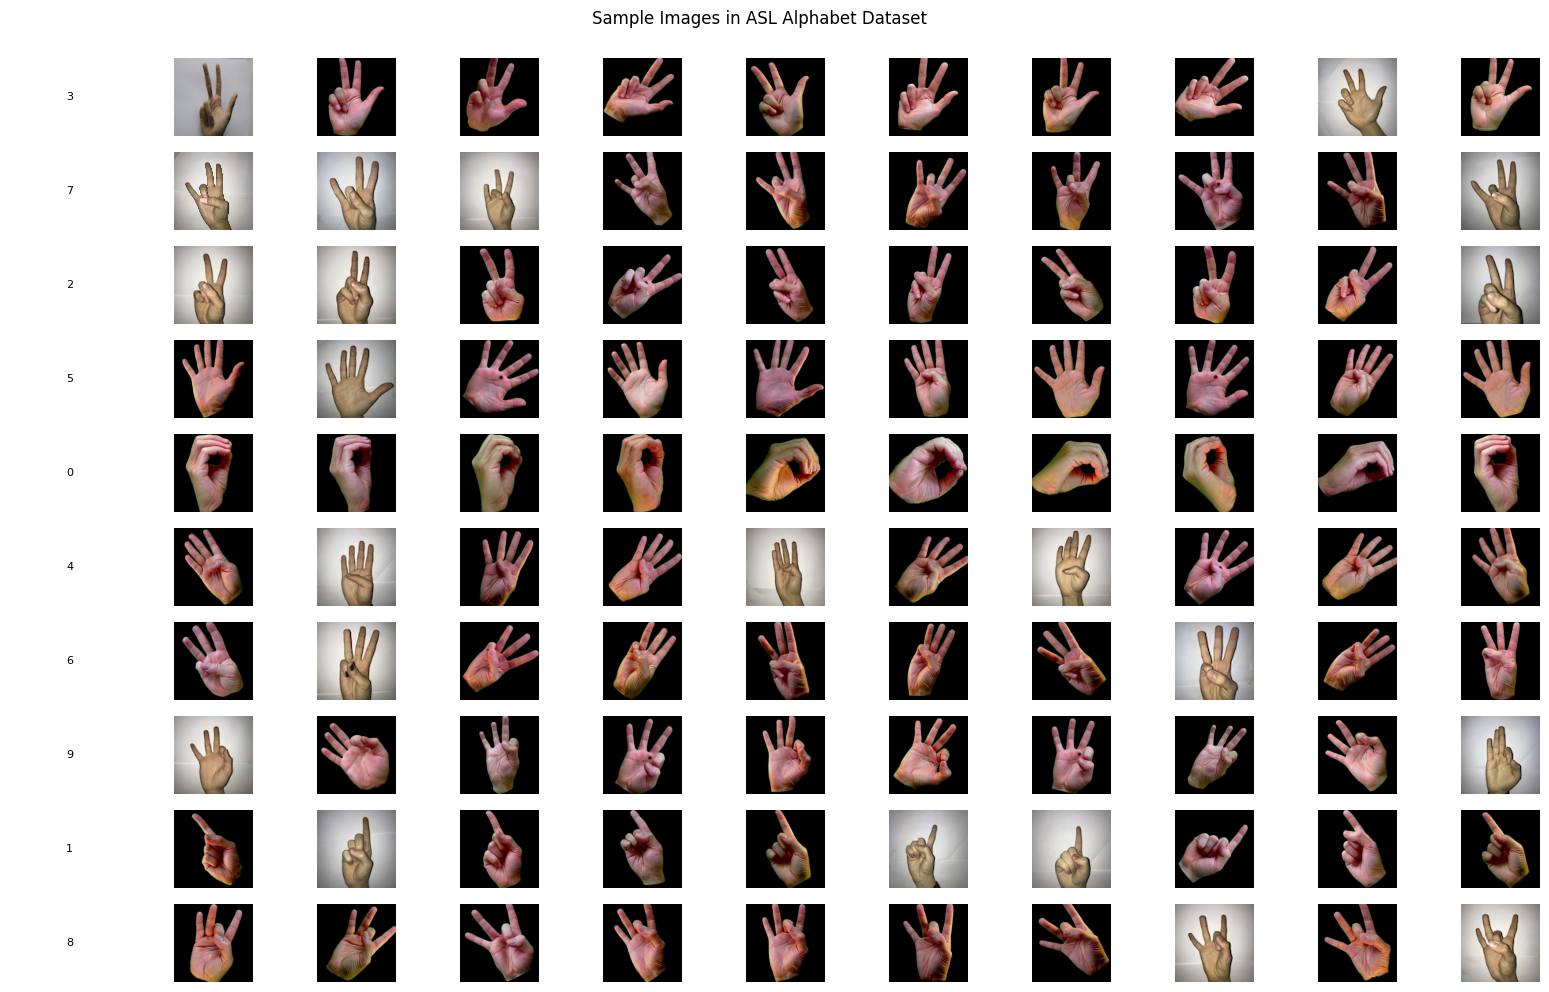

In [ ]:
train_path = training_dir

def sample_images(labels):
    # Create Subplots
    y_size = 12
    if len(labels) < 10:
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 11, figsize=(20, y_size))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(train_path, label)
        list_files = os.listdir(label_path)

        for j in range(10):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.5, y=0.92)

    # Show
    plt.show()

# Example usage
labels = os.listdir(training_dir)
sample_images(labels[:10])

**Create Model**

In [ ]:
pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
)

pretrainedModel.trainable = False

inputs = pretrainedModel.input

# Add new classification layers
x = tf.keras.layers.GlobalAveragePooling2D()(pretrainedModel.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation=tf.nn.relu)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Output layer: 0-9
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer_adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.99 or logs.get('val_accuracy') > 0.98):
            print("\n Accuracy has reached the target, stop")
            self.model.stop_training = True

callback = myCallback()

checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Train Model**

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[callback]
 )

Epoch 1/50
230/230 [==============================] - 117s 456ms/step - loss: 0.7166 - accuracy: 0.7630 - val_loss: 0.3897 - val_accuracy: 0.8543
Epoch 2/50
230/230 [==============================] - 102s 442ms/step - loss: 0.3914 - accuracy: 0.8630 - val_loss: 0.2263 - val_accuracy: 0.9252
Epoch 3/50
230/230 [==============================] - 99s 431ms/step - loss: 0.3004 - accuracy: 0.8965 - val_loss: 0.1735 - val_accuracy: 0.9437
Epoch 4/50
230/230 [==============================] - 102s 442ms/step - loss: 0.2588 - accuracy: 0.9093 - val_loss: 0.1522 - val_accuracy: 0.9415
Epoch 5/50
230/230 [==============================] - 101s 438ms/step - loss: 0.2531 - accuracy: 0.9104 - val_loss: 0.1415 - val_accuracy: 0.9475
Epoch 6/50
230/230 [==============================] - 98s 427ms/step - loss: 0.2264 - accuracy: 0.9183 - val_loss: 0.1334 - val_accuracy: 0.9491
Epoch 7/50
230/230 [==============================] - 101s 441ms/step - loss: 0.2195 - accuracy: 0.9221 - val_loss: 0.1178 - v

**Model Accuracy Visualization**

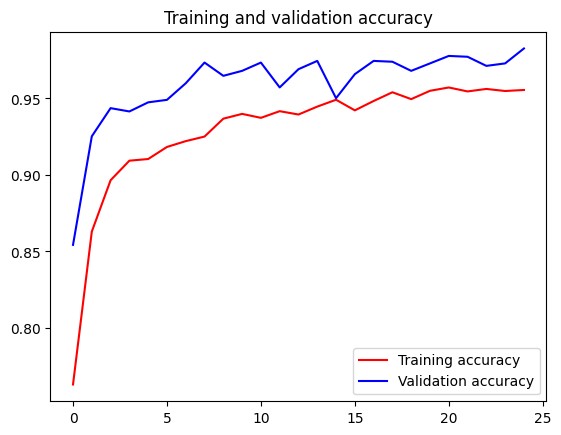

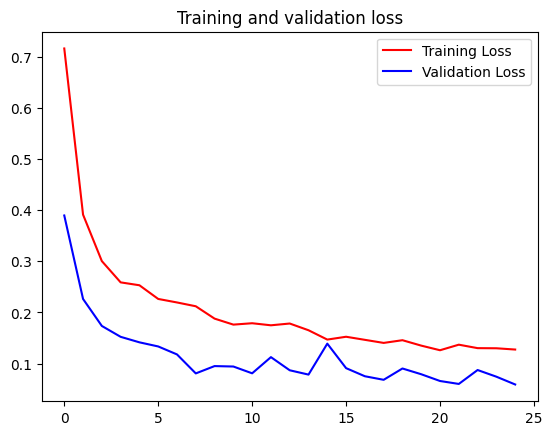

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
input_shape = model.input_shape
output_shape = model.output_shape

print("Input shape:", input_shape)
print("Output shape:", output_shape)

Input shape: (None, 224, 224, 3)
Output shape: (None, 10)


**Save Model to file .h5**

In [ ]:
# The code below is to save model as a .h5 file.
if __name__ == '__main__':
    model.save("model_mobilenetv2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Attempt to implement a model to detect objects through uploaded images**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
# Labels for 10 classes (0-9)
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

uploaded = files.upload()

for fn in uploaded.keys():

  # Load and display images
  path = '/content/' + fn
  img = load_img(path, target_size=(224, 224))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # Convert image to array
  x = img_to_array(img)
  x /= 255.0  # Normalization
  x = np.expand_dims(x, axis=0)

  # Making predictions
  classes = model.predict(x, batch_size=32)

  # Get the class index with the highest probability
  class_idx = np.argmax(classes[0])

  # Get the label of the index
  predicted_label = labels[class_idx]

  print(f"{fn} is predicted as: {predicted_label}")

**Convert Model with TFLite**

In [ ]:
# Load model
model = tf.keras.models.load_model('/content/model_mobilenetv2.h5')

# Create a converter from Keras model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Conversion options (optional, can be further optimized)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert model
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = '/content/number_modelv2.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite models are stored in: {tflite_model_path}")

TFLite models are stored in: /content/number_modelv2.tflite


**Add Metadata**

In [ ]:
!pip install tflite-support

**Option 1**

In [ ]:
import flatbuffers
from tensorflow_lite_support.metadata import metadata_schema_py_generated as _metadata_fb
from tensorflow_lite_support.metadata.python import metadata as _metadata
from tensorflow_lite_support.metadata.python.metadata_writers import writer_utils
from tensorflow_lite_support.metadata.python.metadata_writers import image_classifier
import os

def create_metadata():
    model_meta = _metadata_fb.ModelMetadataT()
    model_meta.name = "ASL Number Classifier"
    model_meta.description = "Identify ASL Number"
    model_meta.version = "v1"
    model_meta.author = "Gesturo"
    model_meta.license = " "

    # Add input info
    input_meta = _metadata_fb.TensorMetadataT()
    input_meta.name = "Input Image"
    input_meta.description = ("Input image to be classified. The expected image is {0} x {1}, with "
        "three channels (red, blue, and green) per pixel. Each value in the "
        "tensor is a single byte between 0 and 255.".format(224, 224))
    input_meta.content = _metadata_fb.ContentT()
    input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
    input_meta.content.contentProperties.colorSpace = (
        _metadata_fb.ColorSpaceType.RGB)
    input_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.ImageProperties)

    input_normalization = _metadata_fb.ProcessUnitT()
    input_normalization.optionsType = (
        _metadata_fb.ProcessUnitOptions.NormalizationOptions)
    input_normalization.options = _metadata_fb.NormalizationOptionsT()
    input_normalization.options.mean = [127.5]
    input_normalization.options.std = [127.5]
    input_meta.processUnits = [input_normalization]

    input_meta.content.range = _metadata_fb.ValueRangeT()
    input_meta.content.range.min = 0
    input_meta.content.range.max = 255
    input_meta.content.stats = _metadata_fb.StatsT()
    input_meta.content.stats.max = [255.0]
    input_meta.content.stats.min = [0.0]
    input_meta.content.shape = [1, 224, 224, 3]

    # Creates output info
    output_meta = _metadata_fb.TensorMetadataT()
    output_meta.name = "probability"
    output_meta.description = "Probabilities of the 10 labels respectively."
    output_meta.content = _metadata_fb.ContentT()
    output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
    output_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.FeatureProperties)
    output_stats = _metadata_fb.StatsT()
    output_stats.max = [1.0]
    output_stats.min = [0.0]
    output_meta.stats = output_stats
    label_file = _metadata_fb.AssociatedFileT()
    label_file.name = os.path.basename("/content/label.txt")
    label_file.description = "Labels for objects that the model can recognize."
    label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
    output_meta.associatedFiles = [label_file]

    # Creates subgraph info.
    group = _metadata_fb.TensorGroupT()
    group.name = "detection result"
    group.tensorNames = [output_meta.name]
    subgraph = _metadata_fb.SubGraphMetadataT()
    subgraph.inputTensorMetadata = [input_meta]
    subgraph.outputTensorMetadata = [output_meta]
    subgraph.outputTensorGroups = [group]
    model_meta.subgraphMetadata = [subgraph]

    b = flatbuffers.Builder(0)
    b.Finish(
        model_meta.Pack(b),
        _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    metadata_buf = b.Output()

    return metadata_buf

# Buat metadata
metadata_buf = create_metadata()

In [ ]:
populator = _metadata.MetadataPopulator.with_model_file("/content/number_model.tflite")
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["/content/label_model.txt"])
populator.populate()

**Option 2**

In [ ]:
!pip install tflite-support-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 31.3 MB/s eta 0:00:00


In [ ]:
ImageClassifierWriter = image_classifier.MetadataWriter

_MODEL_PATH = "/content/number_modelv2.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "/content/label_model.txt"
_SAVE_TO_PATH = "/content/number_modelv2_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba

In [ ]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/number_modelv2_metadata.tflite")
interpreter.allocate_tensors()

# Get input tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Ensure the tensor input is of type float32
input_dtype = input_details[0]['dtype']
if input_dtype == tf.float32:
    print("Input tensor using kTfLiteFloat32")
else:
    print(f"The tensor input does not use kTfLiteFloat32, but rather {input_dtype}")

Input tensor using kTfLiteFloat32
